### Imports

In [2]:
%%capture
!pip install colab-env
import colab_env
!more gdrive/My\ Drive/vars.env
from google.colab import drive
drive.mount('/content/gdrive')

In [3]:
 ## Operations + filereading ##
import os
import argparse
import json
import sys
from pathlib import Path
from collections import defaultdict
import copy
import gc
from pathlib import Path
from shutil import copyfile
from abc import *
from tqdm.notebook import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
import copy
from time import time
from scipy.spatial import distance
import random

## Signal Processing ##
import numpy as np
import pandas as pd
import math
from scipy.spatial.distance import cdist as scipy_distance

## Pytorch + Extras ##
import torch
from torch import nn
import torch.utils.data as data_utils
from   torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn.functional as F
# import torch_geometric.data as data
# import torch_geometric.transforms as transforms
# from torch_geometric.utils.convert import to_networkx
# from torch_geometric.nn import GCNConv,ChebConv
# import torch_geometric.datasets as datasets
import torch.optim as optim

## Visualizations ##
import matplotlib.pyplot as plt
import networkx as nx

## Import helper functions ## 
sourcepath = Path('gdrive/MyDrive/Colab Notebooks/Lottery ticket NILM code')
for file in os.listdir(sourcepath):
  if file.split('.')[-1]=='py':
    copyfile(sourcepath/file,Path(os.getcwd())/file)

from NILM_Dataset import *
from Helper_functions import*
from Graph_Dataset import*

ModuleNotFoundError: ignored

In [ ]:
!nvidia-smi

Tue Mar  1 18:49:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Hyperparameters

In [ ]:
torch.set_default_tensor_type(torch.DoubleTensor)
sys.argv = ['foo']
parser = argparse.ArgumentParser()

parser.add_argument('--data_location',       type = str,   default = None)
parser.add_argument('--export_root',         type = str,   default = None)
parser.add_argument('--seed',                type = int,   default = 0)
parser.add_argument('--device',              type = str,   default = 'cuda' ,    choices=['cpu', 'cuda'])

parser.add_argument('--dataset_code',        type = str,   default = 'uk_dale', choices=['redd_lf', 'uk_dale'])
parser.add_argument('--house_indicies',      type = list,  default = [1, 2, 3, 4, 5])

# REDD Dataset appliance names:    'refrigerator', 'washer_dryer',   'microwave','dishwasher'
# UK Dale Dataset appliance names: 'fridge', 'washing_machine','microwave','dishwasher','kettle'
parser.add_argument('--appliance_names',     type = list,  default = ['microwave'])

parser.add_argument('--sampling',            type = str,   default = '6s')
parser.add_argument('--window_size',         type = int,   default = 480)
parser.add_argument('--window_stride',       type = int,   default = 120)
parser.add_argument('--validation_size',     type = float, default = 0.1)
parser.add_argument('--batch_size',          type = int,   default = 64)

parser.add_argument('--normalize',           type = str,   default = 'mean',    choices=['mean', 'minmax'])
parser.add_argument('--denom',               type = int,   default = 2000)
parser.add_argument('--output_size',         type = int,   default = 1)
parser.add_argument('--drop_out',            type = float, default = 0.1)
parser.add_argument('--mask_prob',           type = float, default = 0.25)

parser.add_argument('--optimizer',           type = str,   default = 'adam',    choices=['sgd', 'adam', 'adamw'])
parser.add_argument('--lr',                  type = float, default = 1e-4) # 5e-4
parser.add_argument('--enable_lr_schedule',  type = bool,  default = False)
parser.add_argument('--weight_decay',        type = float, default = 0.)
parser.add_argument('--momentum',            type = float, default = None)
parser.add_argument('--decay_step',          type = int,   default = 100)
parser.add_argument('--gamma',               type = float, default = 0.1)  #for optimizer
parser.add_argument('--num_epochs',          type = int,   default = 100)

parser.add_argument('--c0',                  type = dict,  default = None)  #temperature value for objective function
parser.add_argument('--cutoff',              type = dict,  default = None)
parser.add_argument('--threshold',           type = dict,  default = None)
parser.add_argument('--min_on',              type = dict,  default = None)
parser.add_argument('--min_off',             type = dict,  default = None)
parser.add_argument('--tau',                 type = float, default = 0.1)



## MARKOV CHAIN ##
parser.add_argument('--num_nodes',           type = int,   default = 20)
parser.add_argument('--mc_order',            type = int,   default = 1)
parser.add_argument('--mc_thres',            type = float, default = 0.015)

parser.add_argument('--normalze',            type = str,   default = 'mean',    choices=['mean', 'minmax'])

parser.add_argument('--latent_len',          type = int,   default = 128)
parser.add_argument('--dropout',             type = float, default = 0.1)
parser.add_argument('--hidden',              type = int,   default = 256)
parser.add_argument('--heads',               type = int,   default = 2)
parser.add_argument('--n_layers',            type = int,   default = 2)


args = parser.parse_args()
args.data_location = 'gdrive/MyDrive/data/'

if torch.cuda.is_available():
    args.device = 'cuda:0'

args.window_stride  = 120 if args.dataset_code == 'redd_lf' else 240
args.house_indicies = [1, 2, 3, 4, 5, 6] if args.dataset_code == 'redd_lf' else [1,2,3,4,5]

if args.dataset_code == 'redd_lf':
    args.cutoff = {
        'aggregate'   : 6000,
        'refrigerator': 400,
        'washer_dryer': 3500,
        'microwave'   : 1800,
        'dishwasher'  : 1200
    }
    args.threshold = {
        'refrigerator': 50,
        'washer_dryer': 20,
        'microwave'   : 200,
        'dishwasher'  : 10
    }
    args.min_on = {
        'refrigerator': 10,
        'washer_dryer': 300,
        'microwave'   : 2,
        'dishwasher'  : 300
    }
    args.min_off = {
        'refrigerator': 2,
        'washer_dryer': 26,
        'microwave'   : 5,
        'dishwasher'  : 300
    }
    args.c0 = {
        'refrigerator': 1e-6,
        'washer_dryer': 0.001,
        'microwave'   : 1.,
        'dishwasher'  : 1.
    }
elif args.dataset_code == 'uk_dale':    
    args.cutoff = {
        'aggregate'      : 6000,
        'kettle'         : 3100,
        'fridge'         : 300,
        'washing_machine': 2500,
        'microwave'      : 3000,
        'dishwasher'     : 2500
    }
    args.threshold = {
        'kettle'         : 2000,
        'fridge'         : 50,
        'washing_machine': 20,
        'microwave'      : 200,
        'dishwasher'     : 10
    }
    #multiply by 6 for seconds
    args.min_on = {
        'kettle'         : 2,
        'fridge'         : 10,
        'washing_machine': 300,
        'microwave'      : 2,
        'dishwasher'     : 300
    }
    #multiply by 6 for seconds
    args.min_off = {
        'kettle'         : 0,
        'fridge'         : 2,
        'washing_machine': 26,
        'microwave'      : 5,
        'dishwasher'     : 300
    }
    args.c0 = {
        'kettle'         : 1.,
        'fridge'         : 1e-6,
        'washing_machine': 0.01,
        'microwave'      : 1.,
        'dishwasher'     : 1.
    }

def setup_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False  
    random.seed(seed)                          
    np.random.seed(seed)                       
    torch.manual_seed(seed)                    
    torch.cuda.manual_seed(seed)               
    torch.cuda.manual_seed_all(seed)           

setup_seed(args.seed)

folder_name = '-'.join(args.appliance_names)
args.export_root = Path('gdrive/MyDrive/experiments/' + args.dataset_code + '/gnn/' + folder_name)

# Graph Creation

### SPLIT DATA INTO SEGMENTS

In [ ]:
if args.dataset_code == 'redd_lf':
    args.house_indicies = [2, 3, 4, 5, 6]
    ds_parser = Redd_Parser(args)
elif args.dataset_code == 'uk_dale':
    args.house_indicies = [1, 3, 4, 5]
    ds_parser = UK_Dale_Parser(args)
    
dataloader              = NILMDataloader(args, ds_parser)
train_loader,val_loader = dataloader.get_dataloaders()

normalize data


### CONVERT DATA TO LISTS

In [ ]:
x_windows,    y_windows,    status_windows     = dl_to_lists(train_loader)
x_windows_val,y_windows_val,status_windows_val = dl_to_lists(val_loader)

### CALCULATE ENTROPY AND CLUSTERS

In [ ]:
# Calculate the entropy (x_windows --> aggregate, y_windows --> signal of the device)
entropies     = [entropy(item) for item in y_windows]
entropies_val = [entropy(item) for item in y_windows_val]

# Create a daframe that holds all the information of traininsg set
training_data  = list(zip(x_windows, entropies, y_windows, status_windows))
training_set   = pd.DataFrame(training_data,
                              columns =['x', 'H', 'y', 'status']
                             )

# Create a daframe that holds all the information of validation set
validation_data = list(zip(x_windows_val, entropies_val, y_windows_val, status_windows_val))
validation_set  = pd.DataFrame(validation_data,
                              columns =['x', 'H', 'y', 'status']
                              )

# Find the minimum and maximum entropy from both training and validation set
# --------------------------------------------------------------------------
min_H = min(training_set['H'].min(),validation_set['H'].min())
max_H = max(training_set['H'].max(),validation_set['H'].max())


# Set the initial boundaries
step                       = (max_H-min_H)/args.num_nodes
entropy_cluster_boundaries = np.arange(start = min_H,stop = max_H, step = step)

# Relocate the initial cluster boundaries using the lloyd algorithm in the whole
# dataset

# Concatenate the entropy values of the training and testing set
entropy_values_training = training_set['H'].values
entropy_values_val      = validation_set['H'].values

entropy_values          = np.concatenate((entropy_values_training,entropy_values_val), axis = 0)

# Calculate the new boundaries of the whole dataset
boundaries,clusters,_,_,_ = compute_quantization(entropy_values,
                                                 entropy_cluster_boundaries,
                                                 force_const_num_assignment_pts=True,
                                                 epsilon=1e-5)

# Add cluster labels on the training set
training_set['label'] = clusters[0:training_set.shape[0]]

# Add cluster lables on the validation set
validation_set['label'] = clusters[training_set.shape[0]:training_set.shape[0] + validation_set.shape[0]]

# Create a dataframe that holds both training and validation set for markov chain
all_data = pd.concat([training_set, validation_set], ignore_index=True, sort=False)

### MARKOV CHAIN FOR EDGES

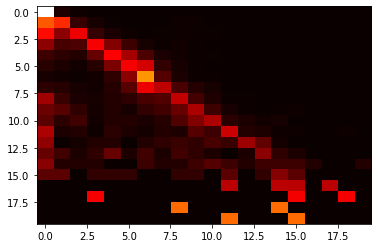

In [ ]:
num_states = all_data.shape[0]-1

P_st = np.zeros((args.num_nodes,1))
P_tr = np.zeros((args.num_nodes,args.num_nodes))

for i in range(num_states):

  curr_state  = all_data.loc[i:i]['label'].values[0]
  next_state  = all_data.loc[i+1:i+1]['label'].values[0]

  P_st[curr_state]            += 1
  P_tr[curr_state,next_state] += 1

P_st = P_st/num_states
P_tr = P_tr/num_states
P_tr = P_tr/P_st


markov_chain = pd.DataFrame(P_tr)
plt.imshow(markov_chain, cmap='hot', interpolation='nearest',aspect='auto')
plt.show()

### GRAPH INITIALIZATION

foo:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
foo:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
foo:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type,

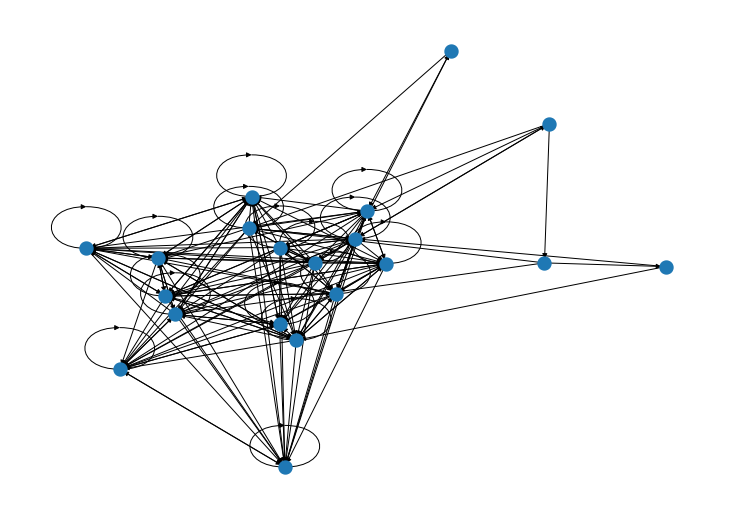

In [ ]:

# Extract edges, and edge weights
# -------------------------------
source     = []
target     = []
edges_attr = []

for i in markov_chain.index:
  for j in markov_chain.columns:
    if markov_chain.loc[i,j] > args.mc_thres:
      source.append(i)
      target.append(j)
      edges_attr.append(markov_chain.loc[i,j])
      
source     = np.array(source, dtype=np.float)
target     = np.array(target, dtype=np.float)
edges_attr = np.array(edges_attr, dtype=np.float)
edges      = torch.Tensor([source,target])

# Represent each cluster as the mean of its allocated segments
# -----------------------------------------------------------
embeddings = []

for i in  np.arange(args.num_nodes):
  cluster = []
  cluster_set = all_data[all_data['label'] == i]['x'].reset_index(drop=True).to_numpy()
  cluster_mean = np.mean([cluster_set[i].numpy() for i in range(cluster_set.shape[0])],
                         axis = 0)
  embeddings.append(cluster_mean)

#Set the correct format for the node embedings and edges
# ------------------------------------------------------
embeddings = torch.Tensor(embeddings)
edges = edges.long()

# Convert the graph information into a PyG Data object
graph = data.Data(x          = embeddings,
                  edge_index = edges,
                  edge_attr  = edges_attr
                  )


# Plot the constructed graph
vis = to_networkx(graph)

plt.figure(1,figsize=(10,7)) 
nx.draw(vis, cmap=plt.get_cmap('Set3'),node_size=70,linewidths=6)
plt.show()

### ENCODER

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self,args):
        super().__init__()
        self.window_size = args.window_size
        self.latent_len  = args.latent_len
        self.step = args.window_size//2
        self.p_drop = args.dropout

        self.conv1   = GCNConv(self.window_size,self.window_size)
        self.conv2   = GCNConv(self.window_size, self.window_size)
        self.conv3   = GCNConv(self.window_size, self.window_size)
        self.conv4   = GCNConv(self.window_size, self.window_size)
        self.conv5   = GCNConv(self.window_size, self.window_size)
        self.conv6   = GCNConv(self.window_size, self.window_size)
        self.conv7  = GCNConv(self.window_size,self.step)
        self.conv8  = GCNConv(self.step, self.latent_len)

        # self.Dropout = nn.Dropout(p = self.p_drop)
        self.activation_1 = nn.ReLU()
        self.activation_2 = nn.Sigmoid() ## DO WE NEED???

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
    
        x = self.activation_1(self.conv1(x, edge_index))
        x = self.activation_1(self.conv2(x, edge_index))
        x = self.activation_1(self.conv3(x, edge_index))
        x = self.activation_1(self.conv4(x, edge_index))
        x = self.activation_1(self.conv5(x, edge_index))
        x = self.activation_1(self.conv6(x, edge_index))
        x = self.activation_1(self.conv7(x, edge_index))
        x = self.activation_2(self.conv8(x, edge_index))

        return x

In [ ]:
# Set the data - model to gpu
# ---------------------------
data= graph.to(args.device)

model = GCN(args)
model = model.to(args.device)

# Neural Message Passing phase
# ----------------------------
convolved_node_data = model.forward(data)

gcn_data = []

for i in all_data['label']:
  gcn_data.append(convolved_node_data[i].cpu().detach().numpy())


# Populate convolved data among training set and validation set
# -------------------------------------------------------------
all_data['z'] = gcn_data

training_set_   = all_data[0:training_set.shape[0]]
validation_set_ = all_data[training_set.shape[0]:training_set.shape[0]+validation_set.shape[0]]

### CREATE TEST DATALOADER

In [ ]:
# Test Dataloader
# ---------------
args.validation_size = 1.
if args.dataset_code == 'redd_lf':
    args.house_indicies = [1]
    ds_parser = Redd_Parser(args)
elif args.dataset_code == 'uk_dale':
    args.house_indicies = [2]
    ds_parser = UK_Dale_Parser(args)

dataloader              = NILMDataloader(args, ds_parser)
_,test_loader = dataloader.get_dataloaders()
    
# Convert Test Dataloader into Lists
# ----------------------------------
x_windows_test,y_windows_test,status_windows_test = dl_to_lists(test_loader)


# Calculate the entropy
# ---------------------
entropies_test = [entropy(item) for item in y_windows_test]


# Create a daframe that holds all the information of testing set
# --------------------------------------------------------------
testing_data  = list(zip(x_windows_test, entropies_test, y_windows_test, status_windows_test))
testing_set   = pd.DataFrame(testing_data,
                             columns =['x', 'H', 'y', 'status']
                            )

# Find the cluster boundaries from the training-validation set 
# as well as the corresponding encoding.
# -------------------------------------------------------------

boundaries = []
encoding   = []

for i in sorted(all_data['label'].unique())[:]:
  boundaries.append((all_data.loc[all_data['label']==i]['H'].min(),all_data.loc[all_data['label']==i+1]['H'].min()))
  encoding.append(all_data.loc[all_data['label']==i]['z'].iloc[0])



# Iterate the H values of the testing set and add the corresponding label, z
# --------------------------------------------------------------------------

testing_labels = []
testing_z      = []

for i in testing_set['H']:
  case = find_case(i,boundaries)
  testing_labels.append(case)
  testing_z.append(encoding[case])


testing_set['label'] = testing_labels
testing_set['z']     = testing_z

normalize data


In [ ]:
# Graph Training dataloader
graph_training_dataset = GraphDataset(training_set_)
graph_train_dataloader = DataLoader(dataset = graph_training_dataset, batch_size=args.batch_size)

# Graph Validation dataloader
graph_val_dataset = GraphDataset(validation_set_)
graph_val_dataloader = DataLoader(dataset = graph_val_dataset, batch_size=args.batch_size)

# Graph Testing dataloader
graph_test_dataset = GraphDataset(testing_set)
graph_test_dataloader = DataLoader(dataset = graph_test_dataset, batch_size=args.batch_size)

### DECODER

In [ ]:
class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

class PositionalEmbedding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pe = nn.Embedding(max_len, d_model)

    def forward(self, x):
        batch_size = x.size(0)
        return self.pe.weight.unsqueeze(0).repeat(batch_size,1, 1)


class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(features))
        self.bias   = nn.Parameter(torch.zeros(features))
        self.eps    = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std  = x.std(-1, keepdim=True)
        return self.weight * (x - mean) / (std + self.eps) + self.bias


class Attention(nn.Module):
    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(query.size(-1))
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)
        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        self.d_k = d_model // h
        self.h   = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)
        self.attention     = Attention()
        self.dropout       = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linear_layers, (query, key, value))]

        x, attn = self.attention(query, key, value, mask = mask, dropout = self.dropout)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1        = nn.Linear(d_model, d_ff)
        self.w_2        = nn.Linear(d_ff, d_model)
        self.activation = GELU()

    def forward(self, x):
        return self.w_2(self.activation(self.w_1(x)))

class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.layer_norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return self.layer_norm(x + self.dropout(sublayer(x)))

class TransformerBlock(nn.Module):
    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        super().__init__()
        self.attention = MultiHeadedAttention(h=attn_heads, d_model=hidden, dropout=dropout)
        self.feed_forward = PositionwiseFeedForward(d_model=hidden, d_ff=feed_forward_hidden)
        self.input_sublayer  = SublayerConnection(size=hidden, dropout=dropout)
        self.output_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask):
        x = self.input_sublayer(x, lambda _x: self.attention.forward(_x, _x, _x, mask=mask))
        x = self.output_sublayer(x, self.feed_forward)
        return self.dropout(x)

In [ ]:
class Transformer_Decoder(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args

        self.original_len = args.window_size
        self.latent_len   = args.latent_len
        self.dropout_rate = args.dropout

        self.hidden       = args.latent_len
        self.heads        = args.heads
        self.n_layers     = args.n_layers
        
        # self.position           = PositionalEmbedding(max_len=self.latent_len, d_model=self.hidden)
        self.dropout            = nn.Dropout(p=self.dropout_rate)

        self.layer_norm         = LayerNorm(self.hidden)

        self.transformer_blocks = nn.ModuleList([TransformerBlock(self.hidden, self.heads, self.hidden * 4, self.dropout_rate) for _ in range(self.n_layers)])


        self.transformer_blocks = nn.ModuleList([nn.TransformerEncoderLayer(self.latent_len,self.heads,self.latent_len,self.dropout_rate,'gelu',batch_first = True) for _ in range(self.n_layers)])

        self.deconv             = nn.ConvTranspose1d(in_channels=self.hidden, out_channels=1, kernel_size=4, stride=2, padding=1)
        self.linear1            = nn.Linear(self.hidden, 512)
        self.linear2            = nn.Linear(512, self.original_len)

        self.truncated_normal_init()

    def truncated_normal_init(self, mean = 0, std = 0.02, lower = -0.04, upper = 0.04):
        params = list(self.named_parameters())
        for n, p in params:
            if 'layer_norm' in n:
                continue
            else:
                with torch.no_grad():
                    l = (1. + math.erf(((lower - mean) / std) / math.sqrt(2.))) / 2.
                    u = (1. + math.erf(((upper - mean) / std) / math.sqrt(2.))) / 2.
                    p.uniform_(2 * l - 1, 2 * u - 1)
                    p.erfinv_()
                    p.mul_(std * math.sqrt(2.))
                    p.add_(mean)

    def forward(self, sequence):

        # embedding = sequence + self.position(sequence)
        # print(embedding.shape)
        # x = self.dropout(self.layer_norm(embedding))
        x = sequence.unsqueeze(1)
        for transformer in self.transformer_blocks:
            x = transformer.forward(x, None)
        x = torch.tanh(self.linear1(x))
        x = self.linear2(x)
        return x.squeeze()

In [ ]:
model = Transformer_Decoder(args).to(args.device)

In [ ]:
def acc_precision_recall_f1_score(pred, status):
    assert pred.shape == status.shape

    pred = pred.reshape(-1, pred.shape[-1])
    status = status.reshape(-1, status.shape[-1])
    accs, precisions, recalls, f1_scores = [], [], [], []

    for i in range(status.shape[-1]):
        tn, fp, fn, tp = confusion_matrix(status[:, i], pred[:, i], labels=[0, 1]).ravel()
        acc            = (tn + tp) / (tn + fp + fn + tp)
        precision      = tp / np.max((tp + fp, 1e-9))
        recall         = tp / np.max((tp + fn, 1e-9))
        f1_score       = 2 * (precision * recall) / np.max((precision + recall, 1e-9))

        accs.append(acc)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)

    return np.array(accs), np.array(precisions), np.array(recalls), np.array(f1_scores)


def relative_absolute_error(pred, label):
    assert pred.shape == label.shape

    pred = pred.reshape(-1, pred.shape[-1])
    label = label.reshape(-1, label.shape[-1])
    temp = np.full(label.shape, 1e-9)
    relative, absolute, sum_err = [], [], []

    for i in range(label.shape[-1]):
        relative_error = np.mean(np.nan_to_num(np.abs(label[:, i] - pred[:, i]) / np.max(
            (label[:, i], pred[:, i], temp[:, i]), axis=0)))
        absolute_error = np.mean(np.abs(label[:, i] - pred[:, i]))

        relative.append(relative_error)
        absolute.append(absolute_error)

    return np.array(relative), np.array(absolute)

In [ ]:
class Trainer(metaclass=ABCMeta):
  def __init__(self,args,model,export_root,graph_train_dataloader,graph_val_dataloader,graph_test_dataloader):
    self.args                = args
    self.device              = args.device
    self.num_epochs          = args.num_epochs
    self.model               = model.to(self.device)
    self.export_root         = Path(export_root)
    self.best_model_epoch    = 0

    self.cutoff      = torch.tensor(args.cutoff[   args.appliance_names[0]]).to(self.device)
    self.threshold   = torch.tensor(args.threshold[args.appliance_names[0]]).to(self.device)
    self.min_on      = torch.tensor(args.min_on[   args.appliance_names[0]]).to(self.device)
    self.min_off     = torch.tensor(args.min_off[  args.appliance_names[0]]).to(self.device)
    self.C0          = torch.tensor(args.c0[       args.appliance_names[0]]).to(self.device)
    self.tau         = args.tau

    self.train_loader = graph_train_dataloader
    self.val_loader   = graph_val_dataloader
    self.test_loader  = graph_test_dataloader
 
    self.optimizer = self._create_optimizer()

    if args.enable_lr_schedule:
      self.lr_scheduler = optim.lr_scheduler.StepLR(self.optimizer,
                                                    step_size=args.decay_step,
                                                    gamma=args.gamma
                                                    )
    self.mse      = nn.MSELoss()
    self.kl       = nn.KLDivLoss(        reduction = 'batchmean')
    self.bceloss  = nn.BCEWithLogitsLoss(reduction = 'mean')
    self.margin   = nn.SoftMarginLoss()
    self.l1_on    = nn.L1Loss(reduction='sum')

    self.val_rel_err, self.val_abs_err = [], []
    self.val_acc, self.val_precision, self.val_recall, self.val_f1 = [], [], [], []
    self.training_loss = []

  def train(self):
    
    val_rel_err, val_abs_err = [], []
    val_acc, val_precision, val_recall, val_f1 = [], [], [], []

    best_rel_err, _, best_acc, _, _, best_f1 = self.validate()
    self._save_state_dict()
  
    #training_loop
    for epoch in range(self.num_epochs):
      self.train_one_epoch(epoch+1)
      rel_err, abs_err, acc, precision, recall, f1 = self.validate()
      val_rel_err.append(rel_err.tolist())
      val_abs_err.append(abs_err.tolist())
      val_acc.append(acc.tolist())
      val_precision.append(precision.tolist())
      val_recall.append(recall.tolist())
      val_f1.append(f1.tolist())

      if f1.mean() + acc.mean() - rel_err.mean() > best_f1.mean() + best_acc.mean() - best_rel_err.mean():
          best_f1      = f1
          best_acc     = acc
          best_rel_err = rel_err
          self.best_model_epoch = epoch
          self._save_state_dict()

      self.val_rel_err.append(np.mean(val_rel_err))
      self.val_abs_err.append(np.mean(val_abs_err))
      self.val_acc.append(np.mean(val_acc))
      self.val_precision.append(np.mean(val_precision))
      self.val_recall.append(np.mean(val_recall))
      self.val_f1.append(np.mean(val_f1))
    
  
  def train_one_epoch(self,epoch):
    loss_values = []
    self.model.train()
    tqdm_dataloader = tqdm(self.train_loader)
    for _,batch in enumerate(tqdm_dataloader):
      seqs, labels_energy, status = [batch[i].to(self.device) for i in range(3)]
      self.optimizer.zero_grad()

      logits        = self.model(seqs)
      logits_energy = self.cutoff_energy(logits * self.cutoff)
      logits_status = self.compute_status(logits_energy)

      labels = labels_energy / self.cutoff

      total_loss = self.loss_fn_train(logits,labels,logits_status,status)
      total_loss.backward(retain_graph=True)
      self.optimizer.step()
      loss_values.append(total_loss.item())

      average_loss = np.mean(np.array(loss_values))
      self.training_loss.append(average_loss)
      tqdm_dataloader.set_description('Epoch {}, loss {:.2f}'.format(epoch, average_loss))

    if self.args.enable_lr_schedule:
        self.lr_scheduler.step()


  def validate(self):
    self.model.eval()
    loss_values, relative_errors, absolute_errors = [], [], []
    acc_values, precision_values, recall_values, f1_values,  = [], [], [], []

    with torch.no_grad():
        tqdm_dataloader = tqdm(self.val_loader)
        for _ , batch in enumerate(tqdm_dataloader):
            seqs, labels_energy, status = [batch[i].to(self.device) for i in range(3)]
            
            labels_energy_np = labels_energy.detach().cpu().numpy().squeeze()
            status_np        = status.detach().cpu().numpy().squeeze()

            logits        = self.model(seqs)
            logits_energy = self.cutoff_energy(logits * self.cutoff)
            logits_status = self.compute_status(logits_energy)
            logits_energy = (logits_energy * logits_status)
            
            logits_status = logits_status.detach().cpu().numpy().squeeze()
            logits_energy = logits_energy.detach().cpu().numpy().squeeze()


            labels = labels_energy / self.cutoff


            rel_err, abs_err = relative_absolute_error(logits_energy, labels_energy_np)
            relative_errors.append(rel_err.tolist())
            absolute_errors.append(abs_err.tolist())

            acc, precision, recall, f1 = acc_precision_recall_f1_score(logits_status, status_np)
            acc_values.append(acc.tolist())
            precision_values.append(precision.tolist())
            recall_values.append(recall.tolist())
            f1_values.append(f1.tolist())
            average_acc     = np.mean(np.array(acc_values     ).reshape(-1))
            average_f1      = np.mean(np.array(f1_values      ).reshape(-1))
            average_rel_err = np.mean(np.array(relative_errors).reshape(-1))

            tqdm_dataloader.set_description('Validation, rel_err {:.2f}, acc {:.2f}, f1 {:.2f}'.format(
                average_rel_err, average_acc, average_f1))

    return_rel_err   = np.array(relative_errors).mean(axis=0)
    return_abs_err   = np.array(absolute_errors).mean(axis=0)
    return_acc       = np.array(acc_values).mean(axis=0)
    return_precision = np.array(precision_values).mean(axis=0)
    return_recall    = np.array(recall_values).mean(axis=0)
    return_f1        = np.array(f1_values).mean(axis=0)
    return return_rel_err, return_abs_err, return_acc, return_precision, return_recall, return_f1

  def test(self,test_loader):
    self._load_best_model()
    self.model.eval()
    loss_values, relative_errors, absolute_errors = [], [], []
    acc_values, precision_values, recall_values, f1_values,  = [], [], [], []

    label_curve  = []
    e_pred_curve = []
    status_curve = []
    s_pred_curve = []
    with torch.no_grad():
        tqdm_dataloader = tqdm(test_loader)
        for _ , batch in enumerate(tqdm_dataloader):
            seqs, labels_energy, status = [batch[i].to(self.device) for i in range(3)]

            labels_energy_np = labels_energy.detach().cpu().numpy().squeeze()
            status_np        = status.detach().cpu().numpy().squeeze()

            logits        = self.model(seqs)
            logits_energy = self.cutoff_energy(logits * self.cutoff)
            logits_status = self.compute_status(logits_energy)
            logits_energy = (logits_energy * logits_status)

            logits_status = logits_status.detach().cpu().numpy().squeeze()
            logits_energy = logits_energy.detach().cpu().numpy().squeeze()

            labels        = labels_energy / self.cutoff


            acc, precision, recall, f1 = acc_precision_recall_f1_score(logits_status, status_np)
            acc_values.append(acc.tolist())
            precision_values.append(precision.tolist())
            recall_values.append(recall.tolist())
            f1_values.append(f1.tolist())

            rel_err, abs_err = relative_absolute_error(logits_energy, labels_energy_np)
            relative_errors.append(rel_err.tolist())
            absolute_errors.append(abs_err.tolist())

            average_acc     = np.mean(np.array(acc_values).reshape(-1))
            average_f1      = np.mean(np.array(f1_values).reshape(-1))
            average_rel_err = np.mean(np.array(relative_errors).reshape(-1))

            tqdm_dataloader.set_description('Test, rel_err {:.2f}, acc {:.2f}, f1 {:.2f}'.format(average_rel_err, average_acc, average_f1))

            label_curve.append( labels_energy_np)
            e_pred_curve.append(logits_energy)
            status_curve.append(status_np)
            s_pred_curve.append(logits_status)

    label_curve  = np.concatenate(label_curve ).reshape(-1,1)
    e_pred_curve = np.concatenate(e_pred_curve).reshape(-1,1)
    status_curve = np.concatenate(status_curve).reshape(-1,1)
    s_pred_curve = np.concatenate(s_pred_curve).reshape(-1,1)

    self.label_curve  = label_curve
    self.e_pred_curve = e_pred_curve
    self.status_curce = status_curve
    self.s_pred_curve = s_pred_curve

    self._save_result({'gt': label_curve.tolist(),'pred': e_pred_curve.tolist()}, 'test_result.json')
    return_rel_err = np.array(relative_errors).mean()
    return_rel_err, return_abs_err = relative_absolute_error(e_pred_curve, label_curve)
    return_acc, return_precision, return_recall, return_f1 = acc_precision_recall_f1_score(s_pred_curve, status_curve)

    return return_rel_err, return_abs_err, return_acc, return_precision, return_recall, return_f1

  def cutoff_energy(self,data):

    data[data<5] = 0
    data = torch.min(data,self.cutoff.double())
    return data
    
  def compute_status(self,data):
    status = (data>=self.threshold)*1
    return status
    
  def loss_fn_train(self,logits,labels,logits_status,status):
    kl_arg_1     = torch.log(F.softmax(logits.squeeze() / 0.1, dim=-1) + 1e-9)
    kl_arg_2     = F.softmax(labels.squeeze() / 0.1, dim=-1)
    mse_arg_1    = logits.contiguous().view(-1).double()
    mse_arg_2    = labels.contiguous().view(-1).double()
    margin_arg_1 = (logits_status * 2 - 1).contiguous().view(-1).double()
    margin_arg_2 = (status * 2 - 1).contiguous().view(-1).double()

    kl_loss      = self.kl( kl_arg_1,  kl_arg_2)
    mse_loss     = self.mse(mse_arg_1, mse_arg_2)
    margin_loss  = self.margin(margin_arg_1, margin_arg_2)
    total_loss   = kl_loss + mse_loss + margin_loss
    
    on_mask = ((status == 1) + (status != logits_status.reshape(status.shape))) >= 1
    if on_mask.sum() > 0:
        total_size  = torch.tensor(on_mask.shape).prod()
        logits_on   = torch.masked_select(logits.reshape(on_mask.shape), on_mask)
        labels_on   = torch.masked_select(labels.reshape(on_mask.shape), on_mask)
        loss_l1_on  = self.l1_on(logits_on.contiguous().view(-1), labels_on.contiguous().view(-1))
        total_loss += self.C0 * loss_l1_on / total_size
    return total_loss

  def _create_optimizer(self):
    args = self.args
    param_optimizer = list(self.model.named_parameters())
    no_decay = ['bias', 'layer_norm']
    optimizer_grouped_parameters = [
        {
            'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay': args.weight_decay,
        },
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]
    if args.optimizer.lower() == 'adamw':
        return optim.AdamW(optimizer_grouped_parameters, lr=args.lr)
    elif args.optimizer.lower() == 'adam':
        return optim.Adam(optimizer_grouped_parameters, lr=args.lr)
    elif args.optimizer.lower() == 'sgd':
        return optim.SGD(optimizer_grouped_parameters, lr=args.lr, momentum=args.momentum)
    else:
        raise ValueError

  def _load_best_model(self):
    try:
      self.model.load_state_dict(torch.load(self.export_root.joinpath('best_acc_model.pth')))
      self.model.to(self.device)
    except:
      print('Failed to load best model, continue testing with current model...')

  def _save_state_dict(self):
    if not os.path.exists(self.export_root):
        os.makedirs(self.export_root)
    print('Saving best model...')
    torch.save(self.model.state_dict(), self.export_root.joinpath('best_acc_model.pth'))

  def _save_values(self,filename):
    if not os.path.exists(self.export_root):
        os.makedirs(self.export_root)
    torch.save(self.model.state_dict(), self.export_root.joinpath('best_acc_model.pth'))

  def _save_result(self,data,filename):
    if not os.path.exists(self.export_root):
      os.makedirs(self.export_root)
    filepath = Path(self.export_root).joinpath(filename)
    with filepath.open('w') as f:
      json.dump(data, f, indent=2)

### TRAINING

In [ ]:
stats = None

In [ ]:
trainer = Trainer(args, model, args.export_root,graph_train_dataloader, graph_val_dataloader,graph_test_dataloader)

In [ ]:
start_time = time()
if args.num_epochs > 0:
  try:
      model.load_state_dict(torch.load(os.path.join(
          args.export_root, 'best_acc_model.pth'), map_location='cpu'))
      print('Successfully loaded previous model, continue training...')
  except FileNotFoundError:
      print('Failed to load old model, continue training new model...')
  trainer.train()

end_time = time()

Failed to load old model, continue training new model...


  0%|          | 0/80 [00:00<?, ?it/s]

Saving best model...


  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

### TESTING

In [ ]:
#training_time = end_time - start_time
training_time = 60

results = dict()
results['args']          = args
results['training_time']  = training_time/60
results['best_epoch']    = trainer.best_model_epoch 
results['training_loss'] = trainer.training_loss
results['val_rel_err']   = trainer.val_rel_err
results['val_abs_err']   = trainer.val_abs_err
results['val_acc']       = trainer.val_acc
results['val_precision'] = trainer.val_precision
results['val_recall']    = trainer.val_recall
results['val_f1']        = trainer.val_f1


import pickle as pkl
fname = Path(args.export_root).joinpath('results.pkl')
pkl.dump(results,open( fname, "wb" ))

args.validation_size = 1.
if args.dataset_code == 'redd_lf':
    args.house_indicies = [1]
    parser = Redd_Parser(args)
elif args.dataset_code == 'uk_dale':
    args.house_indicies = [2]
    parser = UK_Dale_Parser(args)

dataloader = NILMDataloader(args, parser)
_, test_loader = dataloader.get_dataloaders()
mae, mre, acc, prec, recall, f1 = trainer.test(graph_test_dataloader)
print('Mean Accuracy:', acc)
print('Mean F1-Score:', f1)
print('MAE:', mae)
print('MRE:', mre)

normalize data


  0%|          | 0/57 [00:00<?, ?it/s]

Mean Accuracy: [0.99491493]
Mean F1-Score: [0.]
MAE: [0.01358854]
MRE: [6.57303762]
